In [28]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, Dataset
from torchvision import models
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

In [29]:
# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [30]:
# Configuration settings
CONFIG = {
    'checkpoint_path': './my_model_checkpoint.pth',  # Path to your custom checkpoint
    'data_dir': './new_dataset',                     # Path to your new dataset
    'batch_size': 32,
    'num_epochs': 10,
    'learning_rate': 0.0001,                         # Lower learning rate for fine-tuning
    'save_dir': './fine_tuned_model',                # Where to save the fine-tuned model
    'num_classes': 10,                               # Number of classes in new dataset
}

In [31]:
# Create save directory if it doesn't exist
os.makedirs(CONFIG['save_dir'], exist_ok=True)

In [32]:
from PIL import Image

# Custom dataset class for your new data
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = Image.fromarray((image * 255).astype(np.uint8))

        if self.transform:
            image = self.transform(image)

        return image, label

In [33]:
# Define data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [34]:
def load_dummy_data():
    # Create dummy data for demonstration
    # Images should be in format (height, width, channels) with values between 0-1
    X = np.random.rand(1000, 224, 224, 3)  # 1000 RGB images of size 224x224
    y = np.random.randint(0, CONFIG['num_classes'], size=(1000,))

    # Split data into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")
    return X_train, X_val, y_train, y_val

In [35]:
# Load data
X_train, X_val, y_train, y_val = load_dummy_data()

Training samples: 800, Validation samples: 200


In [36]:
# Create datasets
train_dataset = CustomDataset(
    X_train,
    y_train,
    transform=data_transforms['train']
)

val_dataset = CustomDataset(
    X_val,
    y_val,
    transform=data_transforms['val']
)

In [37]:
# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=4
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=4
)

In [38]:
# Function to load a pre-trained model from checkpoint
def load_model_from_checkpoint():
    """
    Load model architecture and weights from a checkpoint file.
    In this example, we're using ResNet50, but you can replace with any model.
    """
    # Initialize the model architecture
    model = models.resnet50()

    # Check if checkpoint exists
    if os.path.exists(CONFIG['checkpoint_path']):
        print(f"Loading model from checkpoint: {CONFIG['checkpoint_path']}")

        # Load checkpoint
        checkpoint = torch.load(CONFIG['checkpoint_path'], map_location='cpu')

        # If the checkpoint contains a state_dict key, load that
        if 'state_dict' in checkpoint:
            model.load_state_dict(checkpoint['state_dict'])
        # Otherwise assume the checkpoint itself is the state_dict
        else:
            model.load_state_dict(checkpoint)

        print("Checkpoint loaded successfully!")
    else:
        print(f"Checkpoint not found at {CONFIG['checkpoint_path']}")
        print("Using pre-trained weights from ImageNet instead.")
        model = models.resnet50(pretrained=True)

    # Modify the final fully connected layer for the new task
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, CONFIG['num_classes'])

    return model

In [39]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """
    Fine-tune the model on the new dataset
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model.to(device)

    # Keep track of training and validation metrics
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Best model tracking
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Wrap train_loader with tqdm for progress bar
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())

        print(f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        # Wrap val_loader with tqdm for progress bar
        for inputs, labels in tqdm(val_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass (no gradient)
            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects.double() / len(val_dataset)

        history['val_loss'].append(epoch_loss)
        history['val_acc'].append(epoch_acc.item())

        print(f"Val Loss: {epoch_loss:.4f}, Val Acc: {epoch_acc:.4f}")

        # Save the best model
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            print(f"Saving new best model with validation accuracy: {best_val_acc:.4f}")

            # Save model checkpoint
            checkpoint = {
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'val_acc': best_val_acc,
                'config': CONFIG
            }

            torch.save(checkpoint, os.path.join(CONFIG['save_dir'], 'best_model.pth'))

        print()

    # Save the final model
    final_checkpoint = {
        'epoch': num_epochs,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'val_acc': epoch_acc,
        'config': CONFIG
    }

    torch.save(final_checkpoint, os.path.join(CONFIG['save_dir'], 'final_model.pth'))
    print(f"Training completed. Final model saved to {os.path.join(CONFIG['save_dir'], 'final_model.pth')}")

    return model, history

In [40]:
# Function to plot training and validation metrics
def plot_metrics(history):
    """
    Plot training and validation loss/accuracy
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['save_dir'], 'training_metrics.png'))
    plt.show()

In [41]:
# Main execution function
def main():
    # Load the model from checkpoint
    model = load_model_from_checkpoint()

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    # Fine-tune all parameters but with a smaller learning rate
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

    # Alternatively, you can freeze the early layers and only train the later ones
    # Uncomment the lines below if you want to try this approach
    """
    # Freeze all layers except the last fully connected layer
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze the FC layer parameters
    for param in model.fc.parameters():
        param.requires_grad = True

    # Only optimize the parameters that require gradients
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=CONFIG['learning_rate'])
    """

    # Train the model
    model, history = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        CONFIG['num_epochs']
    )

    # Plot training metrics
    plot_metrics(history)

    print("Fine-tuning completed!")

Checkpoint not found at ./my_model_checkpoint.pth
Using pre-trained weights from ImageNet instead.
Using device: cuda:0
Epoch 1/10
----------


Training: 100%|██████████| 25/25 [00:12<00:00,  1.94it/s]


Train Loss: 2.3562, Train Acc: 0.1113


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.92it/s]


Val Loss: 2.3974, Val Acc: 0.0850
Saving new best model with validation accuracy: 0.0850

Epoch 2/10
----------


Training: 100%|██████████| 25/25 [00:09<00:00,  2.76it/s]


Train Loss: 2.3461, Train Acc: 0.0963


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.20it/s]


Val Loss: 2.3166, Val Acc: 0.1350
Saving new best model with validation accuracy: 0.1350

Epoch 3/10
----------


Training: 100%|██████████| 25/25 [00:08<00:00,  2.87it/s]


Train Loss: 2.3239, Train Acc: 0.1000


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.10it/s]


Val Loss: 2.3048, Val Acc: 0.1200

Epoch 4/10
----------


Training: 100%|██████████| 25/25 [00:08<00:00,  2.94it/s]


Train Loss: 2.3177, Train Acc: 0.1050


Validation: 100%|██████████| 7/7 [00:01<00:00,  4.51it/s]


Val Loss: 2.3096, Val Acc: 0.0900

Epoch 5/10
----------


Training: 100%|██████████| 25/25 [00:08<00:00,  2.79it/s]


Train Loss: 2.3130, Train Acc: 0.0988


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.01it/s]


Val Loss: 2.3076, Val Acc: 0.1150

Epoch 6/10
----------


Training: 100%|██████████| 25/25 [00:08<00:00,  2.86it/s]


Train Loss: 2.3178, Train Acc: 0.1025


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.09it/s]


Val Loss: 2.3088, Val Acc: 0.1050

Epoch 7/10
----------


Training: 100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 2.3111, Train Acc: 0.0975


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Val Loss: 2.3114, Val Acc: 0.1150

Epoch 8/10
----------


Training: 100%|██████████| 25/25 [00:08<00:00,  2.92it/s]


Train Loss: 2.3064, Train Acc: 0.0950


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.39it/s]


Val Loss: 2.3081, Val Acc: 0.0850

Epoch 9/10
----------


Training: 100%|██████████| 25/25 [00:09<00:00,  2.72it/s]


Train Loss: 2.3120, Train Acc: 0.0887


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.28it/s]


Val Loss: 2.3129, Val Acc: 0.0650

Epoch 10/10
----------


Training: 100%|██████████| 25/25 [00:08<00:00,  2.90it/s]


Train Loss: 2.3001, Train Acc: 0.1113


Validation: 100%|██████████| 7/7 [00:01<00:00,  5.90it/s]


Val Loss: 2.3108, Val Acc: 0.1250

Training completed. Final model saved to ./fine_tuned_model/final_model.pth


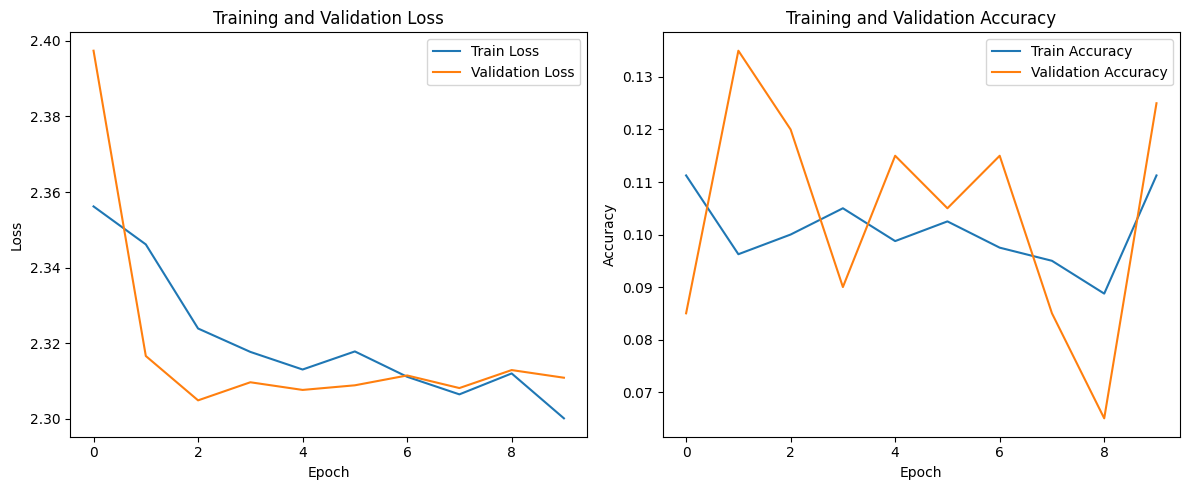

Fine-tuning completed!


In [42]:
if __name__ == "__main__":
    main()